### Problem Statement
Cluster the Iris dataset to categorize iris flowers into distinct groups based on their sepal length, sepal width, petal length, and petal width measurements. The goal is to explore the natural grouping patterns in the dataset and gain insights into the different iris species.

### Data Dictionary:

The Iris dataset is a well-known dataset in the field of machine learning and consists of four features (sepal length, sepal width, petal length, and petal width) and a target variable (species). Here's a data dictionary for the Iris dataset:

Sepal Length (cm): The length of the iris flower's sepal in centimeters.

Sepal Width (cm): The width of the iris flower's sepal in centimeters.

Petal Length (cm): The length of the iris flower's petal in centimeters.

Petal Width (cm): The width of the iris flower's petal in centimeters.

Target Variable:

The target variable is the species of the iris flower, which can belong to one of three classes: ```Setosa, Versicolor, Virginica.```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.set_option("display.max_columns",50)
pd.set_option("display.max_rows",500)

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from scipy.cluster.hierarchy import linkage,dendrogram,cophenet

In [2]:
df=sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
print('No. of Rows',df.shape[0])
print('No. of Varuables',df.shape[1])
print()
print("Number Columns:",df.select_dtypes(np.number).columns.values)
print()
print("Categorical Columns:",df.select_dtypes('object').columns.values)

No. of Rows 150
No. of Varuables 5

Number Columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width']

Categorical Columns: ['species']


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


In [5]:
#class is balanced
print(df['species'].value_counts()*100/len(df))

setosa        33.333333
versicolor    33.333333
virginica     33.333333
Name: species, dtype: float64


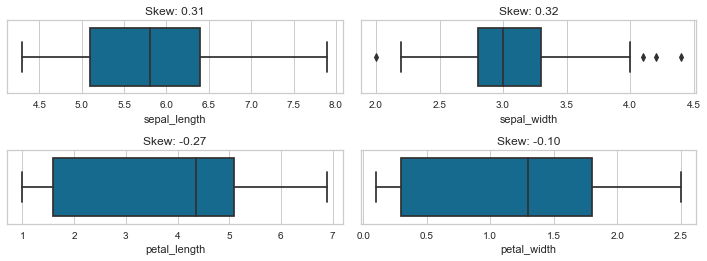

In [6]:
#TREAT THE OUTLIERS
t=1
plt.figure(figsize=(10,7))
for i in df.columns[:-1]:
    plt.subplot(4,2,t)
    sns.boxplot(df[i])
    plt.title('Skew: %.2f'%df[i].skew())
    t+=1
plt.tight_layout()
plt.show()

In [7]:
# no much outliers

In [8]:
#Correlation Table
df.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


In [9]:
#Covariance Table
df.cov()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,0.685694,-0.042434,1.274315,0.516271
sepal_width,-0.042434,0.189979,-0.329656,-0.121639
petal_length,1.274315,-0.329656,3.116278,1.295609
petal_width,0.516271,-0.121639,1.295609,0.581006


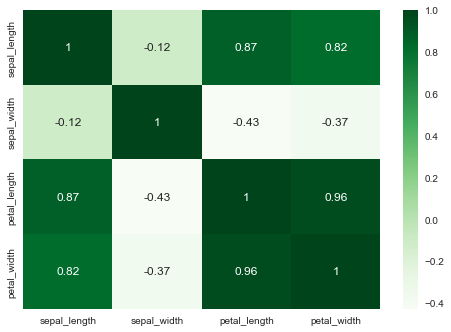

In [10]:
# strong correlation is visible
sns.heatmap(df.corr(),annot=True,cmap='Greens')
plt.show()

In [11]:
df1=df.drop(columns='species')
df1.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


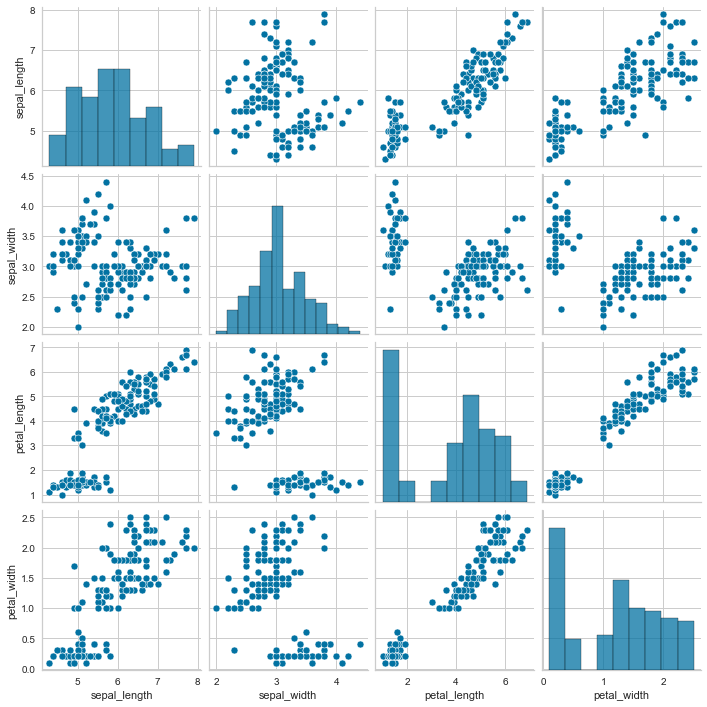

In [12]:
#There are some cluster pattern visible 
sns.pairplot(df1)
plt.show()

In [13]:
# High correlation suggests that the variables are strongly related, and applying PCA may be beneficial to reduce dimensionality
# and remove redundant information.
# Petal length and petal width, sepal length and petal length are highly correlated and suitable for PCA.

In [14]:
# Scale the data before applying PCA
df_scaled=df1.copy()
sc=StandardScaler()
for i in df1.columns:
    df_scaled[i] = sc.fit_transform(pd.DataFrame(df1[i]))

In [15]:
df_scaled.head()

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


In [16]:
pca = PCA(n_components=4)  # Initialize PCA without specifying the number of components
df_pca = pca.fit_transform(df_scaled)

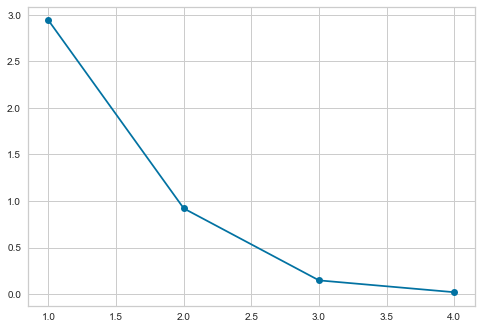

In [17]:
plt.plot(range(1,5),pca.explained_variance_,marker='o') 

In [18]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

num_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
num_components

2

In [19]:
cumulative_variance_ratio
# 2 components explain more than 95% of variance

array([0.72962445, 0.95813207, 0.99482129, 1.        ])

In [20]:
pca = PCA(n_components=2)  # Initialize PCA with number of components=2
df_PCA = pca.fit_transform(df_scaled)

In [21]:
df_PCA = pd.DataFrame(df_PCA,columns=['PC1','PC2'])

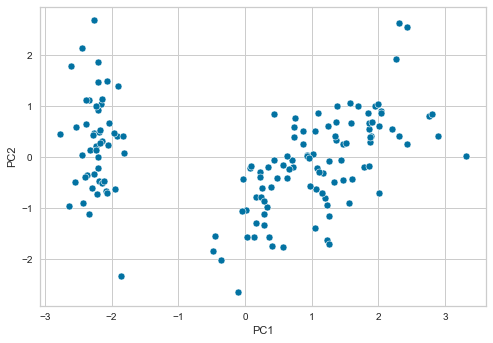

In [22]:
sns.scatterplot(df_PCA['PC1'],df_PCA['PC2'])
plt.show()

In [23]:
#Silhoutte Score
nclus= list(range(2,10))
wcss = []
sil = []
for i in nclus:
    model=KMeans(n_clusters=i)
    model.fit(df_PCA)
    pred=model.predict(df_PCA)
    wcss.append(model.inertia_)
    sil.append(silhouette_score(df_PCA,pred))


In [24]:
pd.DataFrame({'WCSS':wcss,'Sil_Score':sil},index=nclus)

,WCSS,Sil_Score
2,197.403816,0.614520
3,115.020757,0.509168
4,89.347621,0.444508
5,66.199082,0.415581
6,56.853389,0.426470
7,48.399144,0.435288
8,39.106343,0.442350
9,32.080595,0.439791


In [25]:
# Highest Silhouette Score is at n=2

In [26]:
#Elbow Merhod
k_elbow = KElbowVisualizer(KMeans(),k=12)

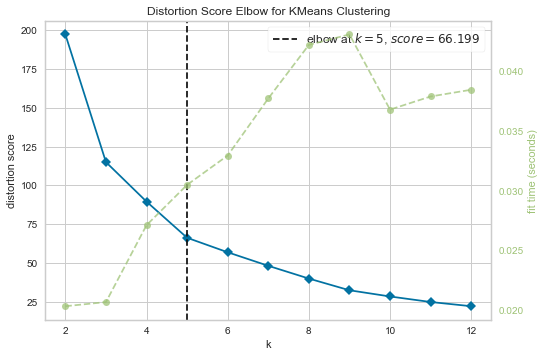

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
k_elbow.fit(df_PCA)
k_elbow.show()

In [28]:
#k=3 seems to be best suited from the above graph

## KMeans Clustering

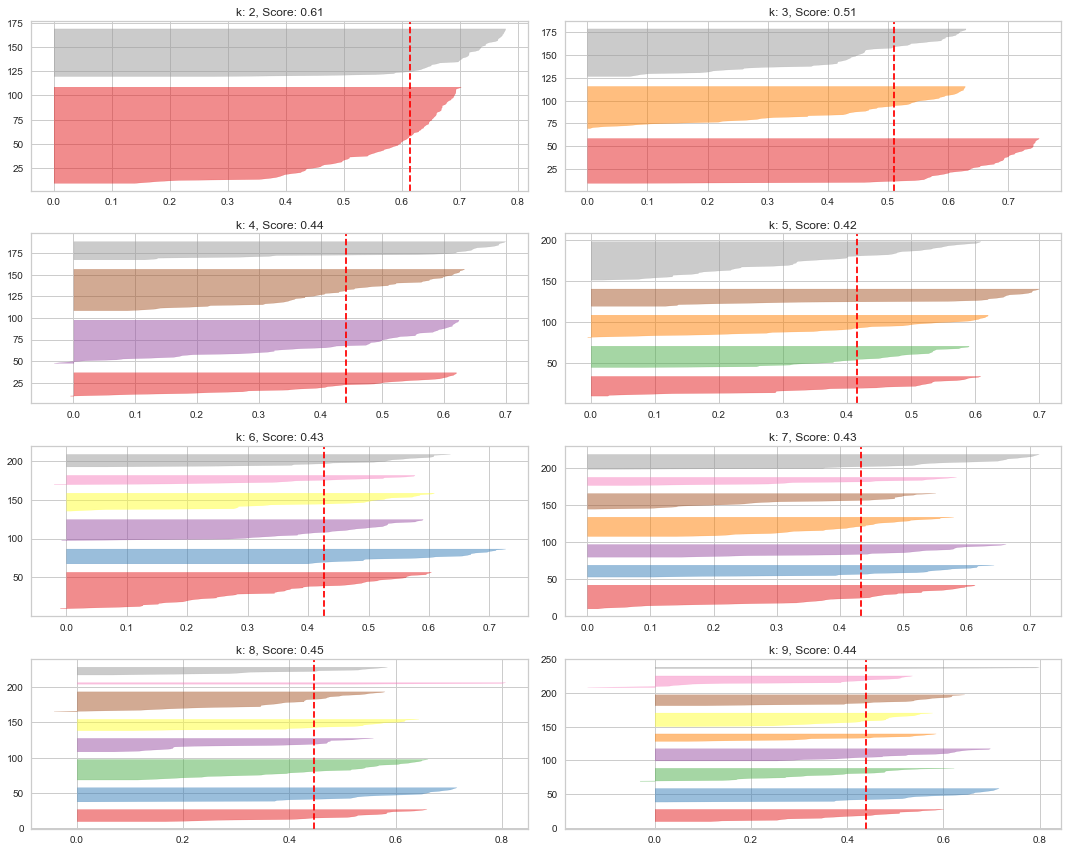

In [29]:
t=1
plt.figure(figsize=(15,12))
for i in nclus:
    plt.subplot(4,2,t)
    model = KMeans(n_clusters=i)
    sil_viz = SilhouetteVisualizer(model)
    sil_viz.fit(df_PCA)
    plt.title('k: %s, Score: %.2f'%(i,sil_viz.silhouette_score_))
    t+=1
plt.tight_layout()
plt.show()

In [30]:
# K=3 seems to be best with no outliers and near equal width

In [31]:
kmean_model = KMeans(n_clusters=3, random_state=42)
kmean_model.fit(df_PCA)

KMeans(n_clusters=3, random_state=42)

In [32]:
y_pred_kmeans = kmean_model.predict(df_PCA)

In [33]:
centroids = kmean_model.cluster_centers_

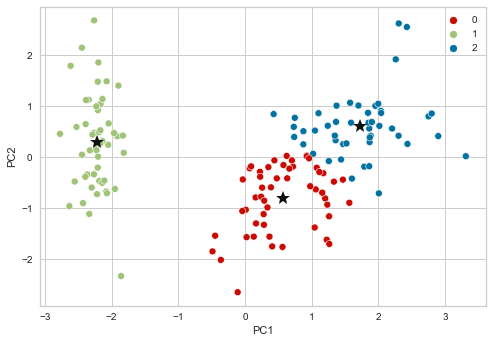

In [34]:
sns.scatterplot(df_PCA['PC1'],df_PCA['PC2'],hue=y_pred_kmeans,
               palette=['r','g','b'])
for i in range(3):
    plt.plot(centroids[i][0],centroids[i][1],marker='*',ms=14,color='k')
plt.show()

## Agglomerative Clustering

In [38]:
link_mat=linkage(df1,method='single')

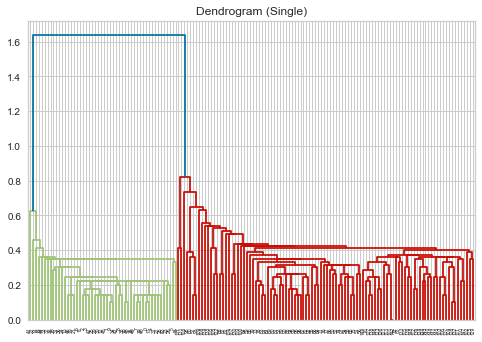

In [39]:
plt.title('Dendrogram (Single)')
dendrogram(link_mat)
plt.axhline(y=12.5)
plt.show()

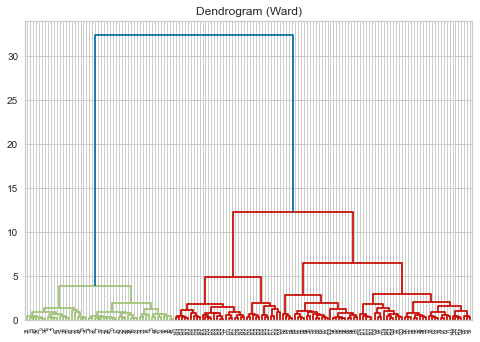

In [41]:
link_mat_ward=linkage(df1,method='ward')
plt.title('Dendrogram (Ward)')
dendrogram(link_mat_ward)
plt.show()

In [42]:
#ward is showing better visualization

In [43]:
# Agglomerative
agglo_model=AgglomerativeClustering(n_clusters=3,linkage='ward')
y_pred=agglo_model.fit_predict(df_PCA)

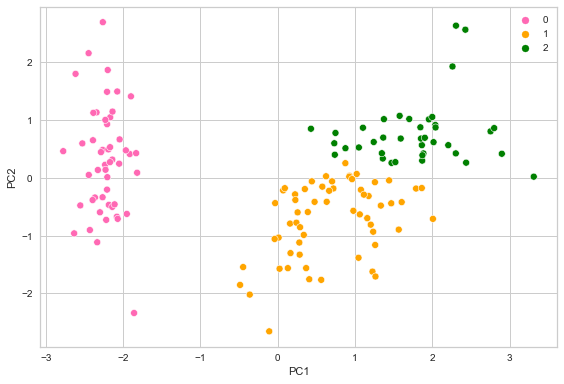

In [44]:
sns.scatterplot(df_PCA['PC1'],df_PCA['PC2'],hue=y_pred,palette=['hotpink','orange','green'])
plt.tight_layout()
plt.show()

In [45]:
#silhoutte score metric
print("KMEANS:",silhouette_score(df_PCA,y_pred_kmeans))
print("AGGLO:",silhouette_score(df_PCA,y_pred))

KMEANS: 0.5091683341538229
AGGLO: 0.511059598876619


In [46]:
# Agglomerative is giving better score. So, we consider Agglomerative Clustering. 

In [47]:
df['Clusters']=y_pred 

In [48]:
X=df.drop(columns=['Clusters','species'])
y=df['Clusters']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score,\
confusion_matrix,cohen_kappa_score,roc_auc_score,roc_curve

In [50]:
def validation(test,pred):
    print('Confusion Matrix\n',confusion_matrix(test,pred))
    print('Accuracy:',accuracy_score(test,pred))
    print('Precison:',precision_score(test,pred,average=None))
    print('Recall:',recall_score(test,pred,average=None))
    print('F1 Score:',f1_score(test,pred,average=None))
    print('Cohen kappa Score:',cohen_kappa_score(test,pred))
    print('Classification Report\n',classification_report(test,pred))

In [51]:
def model_results(model,x_train,y_train,x_test,y_test):
    print(str(model))

    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
   
    validation(y_test,y_pred)    

In [52]:
model_results(DecisionTreeClassifier(max_depth=5),X_train,y_train,X_test,y_test)

DecisionTreeClassifier(max_depth=5)
Confusion Matrix
 [[19  0  0]
 [ 0 13  1]
 [ 0  1 11]]
Accuracy: 0.9555555555555556
Precison: [1.         0.92857143 0.91666667]
Recall: [1.         0.92857143 0.91666667]
F1 Score: [1.         0.92857143 0.91666667]
Cohen kappa Score: 0.9320241691842901
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      0.93      0.93        14
           2       0.92      0.92      0.92        12

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



In [53]:
df.groupby(by='Clusters').mean()

,sepal_length,sepal_width,petal_length,petal_width
Clusters,,,,
0,5.006000,3.428000,1.462000,0.246000
1,5.888525,2.691803,4.485246,1.463934
2,6.846154,3.153846,5.564103,2.007692


In [54]:
df['Flower_Group'] = df['Clusters'].map({0:'Small',1:'Medium',2:'Large'})

In [55]:
del df['Clusters']

<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

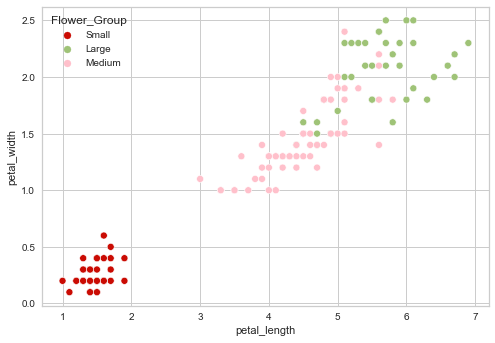

In [61]:
sns.scatterplot(df['petal_length'],df['petal_width'],
               hue=df['Flower_Group'],palette=['r','g','pink'])

<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

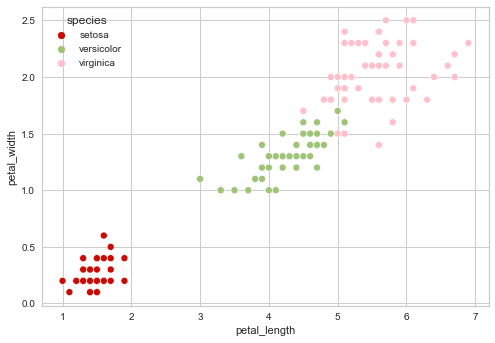

In [62]:
sns.scatterplot(df['petal_length'],df['petal_width'],
               hue=df['species'],palette=['r','g','pink'])

In [67]:
df.groupby(by='species').mean()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


In [103]:
## Error Table
cross_tab=pd.crosstab(df.species,df.Flower_Group)
cross_tab

Flower_Group,Large,Medium,Small
species,,,
setosa,0,0,50
versicolor,9,41,0
virginica,30,20,0


## Conclusion :
There are three groups of flowers based on their size:

    * Small - Setosa
    * Medium - Versicolor
    * Large - Virginica

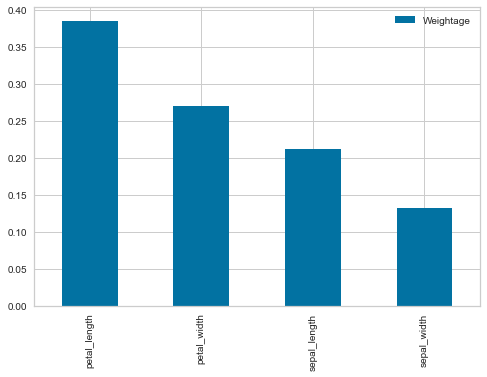

In [58]:
rf = RandomForestClassifier(max_depth=5)

# Fit the model to your data
rf.fit(X_train, y_train)

# Get feature importances
pd.DataFrame(rf.feature_importances_,rf.feature_names_in_,columns=['Weightage']).\
sort_values(by='Weightage',ascending=False).plot(kind='bar')
plt.show()

In [76]:
model_results(DecisionTreeClassifier(max_depth=5),X_train,y_train,X_test,y_test)

DecisionTreeClassifier(max_depth=5)
Confusion Matrix
 [[19  0  0]
 [ 0 13  1]
 [ 0  1 11]]
Accuracy: 0.9555555555555556
Precison: [1.         0.92857143 0.91666667]
Recall: [1.         0.92857143 0.91666667]
F1 Score: [1.         0.92857143 0.91666667]
Cohen kappa Score: 0.9320241691842901
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      0.93      0.93        14
           2       0.92      0.92      0.92        12

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



In [ ]:
# F1-Score came out to be >90%, Thus classification is reliable.

In [101]:
misclassifications = cross_tab.values.trace(offset=-1)

In [102]:
total_data_points = len(df)
misclassification_rate = misclassifications / total_data_points
misclassification_rate

0.19333333333333333

In [ ]:
# So, 0.19 is the misclassification rate of our clustering problem.